In [1]:
from crosscorrelate import test_against_real_data
import numpy as np
import random
import time
import csv
import os
import math
from multiprocessing import Pool

In [2]:
def create_new_set(setlength):
    new_set = []
    for i in range(setlength):
        new_set.append(round(random.random(),4))
    count = 0
    for k in new_set:
        i = round(k, 4)
        new_set[count] = i
        count += 1

        return new_set

In [3]:
from PyTCI.weights import leanbodymass
from PyTCI.models import propofol
from patient_solver import solve_for_patient

class New_model(propofol.Propofol):
    def __init__(self, age, weight, height, sex, params):
        
        lean_body_mass = leanbodymass.hume66(height, weight, sex)
        
        self.v1 = ((params[1] * 50) - params[2]*(age - (params[3] * 100))) * (params[4] * (lean_body_mass - (params[5] * 100)))
        self.v2 = params[6] * lean_body_mass * 2
        self.v3 = params[7] * weight * 5
        
        self.Q1 = ((params[8] * self.v1) * (params[9] * age)) ** 0.75
        self.Q2 = (params[9] * self.v2)** 0.75
        self.Q3 = (params[0] * self.v3) ** 0.75
        
        self.keo = 0
        
        propofol.Propofol.from_clearances(self)
        propofol.Propofol.setup(self)
                                                         
                   
                   
                   
def solve_for_custom(patient, params):
    patient_model = New_model(patient["age"], patient["weight"], patient["height"], patient["sex"], params )
    return solve_for_patient(patient_model, patient["events"])

In [4]:
def create_new_population(size, setlength):
    pop_size = size
    pop_list = []
    for i in range(pop_size):
        newparam = create_new_set(setlength)
        pop_list.append(newparam)
    return pop_list

In [5]:
def test_population(pop, best, second, one, two):

    best_fitness = best[1]
    second_fitness = second[1]

    fittest_set = one
    second_set = two
    #print "best: " + str(best_fitness)

    #switching between the tuple and value is confusing and i'm getting upset
    pop_list = []
    for i in pop:
        try:
            result = multi_core_test(cores, max, i)
            fitness = result[1]

            pop_list.append([fitness, i, result])

        except:
            result = (99, 99, 99)




    pop_list.sort()
    #output = (fittest_set, best, second_set, second)
    output = (pop_list[0][1], pop_list[0][2], pop_list[1][1], pop_list[1][2])

    return output

In [6]:
def mutate_population(children, fittest, second, mutants):
    pop_list = []

    def mutate_chromosome(chrome):
        b = random.random()
        c = len(fittest)
        c = 1 / c
        if b < (c/2):
            chrome = chrome * np.random.normal(1, 0.3)
        elif b < c:
            chrome = chrome * np.random.normal(1, 0.1)
        else:
            chrome = chrome * 1
        return round(chrome, 6)

    # breed parents to create children
    def breed(sprogs, p1, p2):
        for i in range(sprogs):
            child = []
            count = 0
            for k in p1:
                a = random.random()
                if a < 0.5:
                    k = p2[count]
                    k = mutate_chromosome(k)
                    child.append(k)
                else:
                    k = mutate_chromosome(k)
                    child.append(k)

                count += 1
            pop_list.append(child)

    breed(children, fittest, second)

    # immigration to escape local minima
    rand1 = create_new_set(len(fittest))
    rand2 = create_new_set(len(fittest))

    pop_list.append(rand1)
    pop_list.append(rand2)

    breed(2, fittest, rand1)
    breed(2, fittest, rand2)

    # create mutants of fittest
    for i in range(mutants):
        mutant = []
        for k in fittest:
            b = random.random()
            if b < 0.2:
                mut_factor = 0.3
            else:
                mut_factor = 0.1
            k = k * np.random.normal(1, mut_factor)
            k = round(k, 4)
            mutant.append(k)
        pop_list.append(mutant)

    return pop_list

In [7]:
def multi_core_test(cores, maxpt, params):
    # TODO change this so params can be any size

    step_size = round(maxpt / cores)

    jobs = []

    for idx in range(cores):
        a = step_size * idx + 1
        b = step_size * (idx + 1)
        if idx == (cores-1):
            b = maxpt
        thing = (a, b, params)
        jobs.append(thing)

    pool = Pool(cores)
    
    results = pool.map(test_against_real_data, jobs)

    # make this dynamic, cast to float?
    rms = sum([thing[0] for thing in results]) / cores
    meds = sum([thing[1] for thing in results]) / cores
    bias = sum([thing[2] for thing in results]) / cores

    # "%-15s %-15s" % (rms, meds)
    data = (rms, meds, bias)

    # return meds
    return data

In [8]:
from csvreader import read_patient_csv

def test_against_real_data(stuff):
    pmin = stuff[0]
    pmax = stuff[1]
    params = stuff[2]
    patients = read_patient_csv()

    #totalrms = 0
    totalmed = 0
    totalbias = 0
    count = 0

    for patient in patients[pmin:pmax]:
        res = solve_for_custom(patient, params)
        #a = res["percent"]
        med = res["median"]
        bias = res["bias"]

        #totalrms += a
        totalbias += bias
        totalmed += med
        count += 1

    #b = totalrms / count
    c = totalmed / count
    d = totalbias / count
    
    #use pythagorus to calculate score to optimise both performance error and bias
    e = 1/(1+math.exp(-d))
    b = math.hypot(c, e)

    data = (b, c, d)
    return data

In [9]:
import time
from IPython import display
from multiprocessing import Pool
import matplotlib.pyplot as plt


print("creating population")
pop = create_new_population(10, 10)
pool = Pool(2)


def test_population(pop):

    pop_list = []
    for i in pop:
#         stuff = (1, 50, i)
#         result = multi_core_test(2, 100, i)
#         fitness = result[0]
#         pop_list.append([fitness, i, result])
        try:
            result = multi_core_test(2, 100, i)
            fitness = result[1]
            pop_list.append([fitness, i, result])

        except:
            result = (99, 99, 99)
            fitness = result[1]
            pop_list.append([fitness, i, result])
    
    pop_list.sort()
    output = (pop_list[0][1], pop_list[0][2], pop_list[1][1], pop_list[1][2])

    return output

print("beginning test")
fit_results = test_population(pop)

fittest_set = fit_results[0]
best_fitness = fit_results[1][1]
second_set = fit_results[2]
second_fitness = fit_results[3][1]

max_tries = 0
while best_fitness > 9.9:
    fit_results = test_population(pop)
    best_fitness = fit_results[1][1]
    
    print ("trying again")    

pltB = []
pltS = []


print("starting")
# 
for _ in range(30):
    
   
    new_pop = mutate_population(10, fittest_set, second_set, 10)
    fit_results = test_population(new_pop) 
    
    if fit_results[1][0] < 99:
        fittest_set = fit_results[0]
        best_fitness = fit_results[1][0]
        second_set = fit_results[2]
        second_fitness = fit_results[3][0]

        print(fit_results[1])
        
        pltB.append(fit_results[1][0])
        pltS.append(fit_results[1][1])

print(fittest_set)
print ("finished!!")

creating population
beginning test
starting
(1.3165973556128852, 0.8604228281989098, 5.738493265849037)
(1.232053539505788, 0.7294834082353113, 4.986454043656815)
(1.1622989964372485, 0.6190850958594312, 4.149432506410736)
(0.8666261976274141, 0.375527729333493, 1.3741209475160898)
(0.8556014373084374, 0.3382470517161593, 1.3792829902581185)
(0.8727703389438461, 0.3300362330160949, 1.5177991552129468)
[0.9643, 0.0731, 0.0419, 0.6198, 0.0966, 0.1809, 0.0168, 0.0354, 0.2507, 0.0207]
finished!!


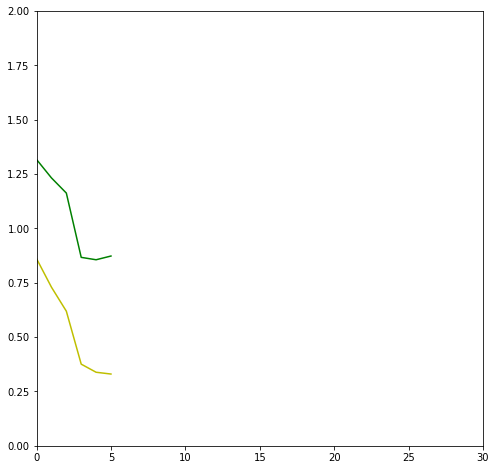

In [10]:
plt.figure(figsize=(8,8))
plt.axis([0, 30, 0, 2])
plt.plot(pltB, 'g', pltS, 'y')